In [7]:
# import pickle
import json  # 存loss, acc
# import random
import numpy as np
import matplotlib.pyplot as plt
# from abc import ABCMeta, abstractmethod
#################################################
import cv2
# import matplotlib.pyplot as plt
# import math

import os
import multiprocessing as mp
from tqdm import tqdm
import time
#################################################
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from thop import profile
# from ptflops import get_model_complexity_info

In [8]:
# print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

In [ ]:
with open("./train.txt") as f:
    train_file_list = f.readlines()
with open("./val.txt") as f:
    val_file_list = f.readlines()
with open("./test.txt") as f:
    test_file_list = f.readlines()

train_file_list = [x.strip().split(sep=" ") for x in train_file_list]
val_file_list = [x.strip().split(sep=" ") for x in val_file_list]
test_file_list = [x.strip().split(sep=" ") for x in test_file_list]

train_label = [int(x[1]) for x in train_file_list]
val_label = [int(x[1]) for x in val_file_list]
test_label = [int(x[1]) for x in test_file_list]

train_file_list = [x[0] for x in train_file_list]
val_file_list = [x[0] for x in val_file_list]
test_file_list = [x[0] for x in test_file_list]

# print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

def ReadImage(filePath):
    image = cv2.imread(filePath, cv2.IMREAD_COLOR)
    # image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    # image = cv2.resize(image, (256, 256))
    return image

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_imgs = pool.map(ReadImage, tqdm(train_file_list))
    val_imgs = pool.map(ReadImage, tqdm(val_file_list))
    test_imgs = pool.map(ReadImage, tqdm(test_file_list))

# resize the images to 256x256
def ResizeImage(image):
    # resized_img = cv2.resize(image, (256, 256))
    resized_img = cv2.resize(image, (32, 32))
    return resized_img

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(ResizeImage, tqdm(train_imgs))
    resized_val_imgs = pool.map(ResizeImage, tqdm(val_imgs))
    resized_test_imgs = pool.map(ResizeImage, tqdm(test_imgs))


In [ ]:
np.save(file="./data/resized_train_imgs.npy", arr=resized_train_imgs)
np.save(file="./data/resized_val_imgs.npy", arr=resized_val_imgs)
np.save(file="./data/resized_test_imgs.npy", arr=resized_test_imgs)
np.save(file="./data/train_label", arr=train_label)
np.save(file="./data/val_label", arr=val_label)
np.save(file="./data/test_label", arr=test_label)

In [9]:
resized_train_imgs = np.load(file="./data/resized_train_imgs.npy")
resized_val_imgs = np.load(file="./data/resized_val_imgs.npy")
resized_test_imgs = np.load(file="./data/resized_test_imgs.npy")
train_label = np.load(file="./data/train_label.npy")
val_label = np.load(file="./data/val_label.npy")
test_label = np.load(file="./data/test_label.npy")

In [10]:
def MoveColorChannel(image: np.ndarray) -> np.ndarray:
    return np.moveaxis(image, source=2, destination=0)  # reshape (H, W, C) to (C, H, W)

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(MoveColorChannel, tqdm(resized_train_imgs))
    resized_val_imgs = pool.map(MoveColorChannel, tqdm(resized_val_imgs))
    resized_test_imgs = pool.map(MoveColorChannel, tqdm(resized_test_imgs))


100%|██████████| 450/450 [00:00<00:00, 41045.51it/s]


In [11]:
# convert list to numpy.ndarray
resized_train_imgs = np.array(resized_train_imgs)
resized_val_imgs = np.array(resized_val_imgs)
resized_test_imgs = np.array(resized_test_imgs)
# list to numpy.ndarray
train_label = np.array(train_label)
val_label = np.array(val_label)
test_label = np.array(test_label)

In [12]:
# check the shape
print(resized_train_imgs.shape)
print(resized_val_imgs.shape)
print(resized_test_imgs.shape)
print()
print(train_label.shape)
print(val_label.shape)
print(test_label.shape)

(63325, 3, 32, 32)
(450, 3, 32, 32)
(450, 3, 32, 32)

(63325,)
(450,)
(450,)


In [13]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = resized_train_imgs, train_label, \
                                                 resized_val_imgs, val_label, \
                                                 resized_test_imgs, test_label
# normalization
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_val -= np.mean(X_val)
X_test -= np.mean(X_test)


# TensorDataset
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
# X_train = X_train.permute(0, 3, 1, 2)
# X_val = X_val.permute(0, 3, 1, 2)
# X_test = X_test.permute(0, 3, 1, 2)

Y_train = torch.IntTensor(Y_train)
Y_val = torch.IntTensor(Y_val)
Y_test = torch.IntTensor(Y_test)

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

BATCH_SIZE = 64
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)

In [14]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
        self.activ1 = nn.Sigmoid()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.activ2 = nn.Sigmoid()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.activ3 = nn.Sigmoid()
        self.fc2 = nn.Linear(120, 84)
        self.activ4 = nn.Sigmoid()
        self.fc3 = nn.Linear(84, 50)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activ1(self.conv1(x))
        x = self.pool1(x)
        x = self.activ2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.activ3(self.fc1(x))
        x = self.activ4(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on {device}.")

Training on cuda.


In [12]:
model = LeNet5().to(device)
EPOCHS = 30
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def compute_accuracy(predictions, labels):
    # Compare predicted labels with ground truth labels
    # correct = (predictions == labels).sum().item()
    correct = torch.eq(predictions, labels).sum().item()
    # Calculate accuracy
    accuracy = correct / labels.size(0) * 100
    return accuracy

def train(model, train_dataloader, val_dataloader, loss_fcn, optimizer, n_epochs):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(n_epochs):
        train_loss, val_loss = 0.0, 0.0
        train_acc, val_acc = 0.0, 0.0

        # Training
        model.train()
        with tqdm(total=len(train_dataloader)) as pbar:
            for imgs, labels in train_dataloader:
                imgs, labels = imgs.to(device), labels.type(torch.LongTensor).to(device)
                # Forward pass
                outputs = model(imgs)  # Tensor
                preds = torch.argmax(outputs, dim=1)  # Tensor
                train_acc += compute_accuracy(preds, labels)
                # Compute loss
                loss = loss_fcn(outputs, labels)
                train_loss += loss
                # Backward propagation
                optimizer.zero_grad()
                loss.backward()
                # Gradient descent
                optimizer.step()
                # Update tqdm progress bar
                pbar.update(1)

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        # Print training loss and training accuracy for every some epochs
        if epoch % 1 == 0:
            print(f"Epoch: {epoch + 1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} %")

        # Validation
        model.eval()
        with torch.inference_mode():
            for X, y in val_dataloader:
                X, y = X.to(device), y.type(torch.LongTensor).to(device)
                val_prob = model(X)
                val_pred = torch.argmax(val_prob, dim=1)

                val_loss += loss_fcn(val_prob, y)
                val_acc += compute_accuracy(val_pred, y)

            val_loss /= len(val_dataloader)
            val_acc /= len(val_dataloader)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list


train_loss_list, train_acc_list, val_loss_list, val_acc_list = train(model=model,
                                                                     train_dataloader=train_dataloader,
                                                                     val_dataloader=val_dataloader,
                                                                     loss_fcn=criterion,
                                                                     optimizer=optimizer,
                                                                     n_epochs=EPOCHS)


100%|██████████| 990/990 [00:15<00:00, 63.23it/s]

Epoch: 1 | Train loss: 3.9058 | Train acc: 2.8741 %



100%|██████████| 990/990 [00:15<00:00, 63.56it/s] 

Epoch: 2 | Train loss: 3.8879 | Train acc: 5.2084 %



100%|██████████| 990/990 [00:18<00:00, 53.83it/s] 

Epoch: 3 | Train loss: 3.8774 | Train acc: 6.5411 %



100%|██████████| 990/990 [00:13<00:00, 72.96it/s] 

Epoch: 4 | Train loss: 3.8721 | Train acc: 7.0739 %



100%|██████████| 990/990 [00:15<00:00, 62.62it/s] 

Epoch: 5 | Train loss: 3.8671 | Train acc: 7.6348 %



100%|██████████| 990/990 [00:11<00:00, 83.08it/s] 

Epoch: 6 | Train loss: 3.8619 | Train acc: 8.1951 %



100%|██████████| 990/990 [00:15<00:00, 64.17it/s] 

Epoch: 7 | Train loss: 3.8563 | Train acc: 8.8434 %



100%|██████████| 990/990 [00:11<00:00, 83.99it/s] 

Epoch: 8 | Train loss: 3.8513 | Train acc: 9.4508 %



100%|██████████| 990/990 [00:19<00:00, 51.71it/s] 

Epoch: 9 | Train loss: 3.8465 | Train acc: 9.9154 %



100%|██████████| 990/990 [00:11<00:00, 82.82it/s] 

Epoch: 10 | Train loss: 3.8421 | Train acc: 10.3526 %



100%|██████████| 990/990 [00:17<00:00, 57.34it/s] 

Epoch: 11 | Train loss: 3.8376 | Train acc: 10.8517 %



100%|██████████| 990/990 [00:13<00:00, 73.30it/s] 

Epoch: 12 | Train loss: 3.8316 | Train acc: 11.4656 %



100%|██████████| 990/990 [00:17<00:00, 57.63it/s] 

Epoch: 13 | Train loss: 3.8275 | Train acc: 11.9133 %



100%|██████████| 990/990 [00:14<00:00, 68.18it/s] 

Epoch: 14 | Train loss: 3.8220 | Train acc: 12.4845 %



100%|██████████| 990/990 [00:16<00:00, 59.65it/s] 

Epoch: 15 | Train loss: 3.8186 | Train acc: 12.8681 %



100%|██████████| 990/990 [00:16<00:00, 60.93it/s] 

Epoch: 16 | Train loss: 3.8151 | Train acc: 13.1821 %



100%|██████████| 990/990 [00:14<00:00, 68.17it/s] 

Epoch: 17 | Train loss: 3.8120 | Train acc: 13.4508 %



100%|██████████| 990/990 [00:16<00:00, 58.61it/s]

Epoch: 18 | Train loss: 3.8084 | Train acc: 13.9110 %



100%|██████████| 990/990 [00:12<00:00, 77.66it/s] 

Epoch: 19 | Train loss: 3.8056 | Train acc: 14.1304 %



100%|██████████| 990/990 [00:15<00:00, 63.60it/s] 

Epoch: 20 | Train loss: 3.8031 | Train acc: 14.4719 %



100%|██████████| 990/990 [00:13<00:00, 76.08it/s] 

Epoch: 21 | Train loss: 3.8009 | Train acc: 14.6837 %



100%|██████████| 990/990 [00:20<00:00, 47.26it/s]

Epoch: 22 | Train loss: 3.7977 | Train acc: 15.0364 %



100%|██████████| 990/990 [00:12<00:00, 79.08it/s] 

Epoch: 23 | Train loss: 3.7952 | Train acc: 15.2861 %



100%|██████████| 990/990 [00:16<00:00, 59.71it/s] 

Epoch: 24 | Train loss: 3.7933 | Train acc: 15.4691 %



100%|██████████| 990/990 [00:12<00:00, 77.31it/s] 

Epoch: 25 | Train loss: 3.7910 | Train acc: 15.6415 %



100%|██████████| 990/990 [00:16<00:00, 58.84it/s] 

Epoch: 26 | Train loss: 3.7889 | Train acc: 15.8283 %



100%|██████████| 990/990 [00:14<00:00, 70.32it/s] 

Epoch: 27 | Train loss: 3.7865 | Train acc: 16.1380 %



100%|██████████| 990/990 [00:15<00:00, 62.52it/s] 

Epoch: 28 | Train loss: 3.7844 | Train acc: 16.3021 %



100%|██████████| 990/990 [00:13<00:00, 72.52it/s] 

Epoch: 29 | Train loss: 3.7826 | Train acc: 16.5591 %



100%|██████████| 990/990 [00:12<00:00, 77.90it/s] 

Epoch: 30 | Train loss: 3.7788 | Train acc: 16.9786 %


In [14]:
# save params
# weights = model.get_params()
# with open("pytorch_model.pkl","wb") as f:
# 	pickle.dump(weights, f)
torch.save(model.state_dict(), './model/pytorch_model.pt')

# train_loss_list = [x.cpu().item() for x in train_loss_list]
# val_loss_list = [x.cpu().item() for x in val_loss_list]
# train_acc_list = [x.cpu().item() for x in train_acc_list]
# val_acc_list = [x.cpu().item() for x in val_acc_list]
# train_loss_list = np.array(train_loss_list).tolist()
# val_loss_list = np.array(val_loss_list).tolist()
# train_acc_list = np.array(train_acc_list).tolist()
# val_acc_list = np.array(val_acc_list).tolist()
# save loss, accuracy
# with open("./loss/pytorch_model_train_loss.txt", "w") as fp:
# 	json.dump(train_loss_list, fp)
# with open("./loss/pytorch_model_val_loss.txt", "w") as fp:
# 	json.dump(val_loss_list, fp)
# with open("./acc/pytorch_model_train_acc.txt", "w") as fp:
# 	json.dump(train_acc_list, fp)
# with open("./acc/pytorch_model_val_acc.txt", "w") as fp:
# 	json.dump(val_acc_list, fp)


In [ ]:
# load params
# with open("pytorch_model.pkll", "rb") as f:
# 	model.set_params(params=pickle.load(f))
model = LeNet5()
model.load_state_dict(torch.load('./model/pytorch_model.pt')).to(device)

# load loss, accuracy
with open("./loss/pytorch_model_train_loss.txt", "r") as fp:
	train_loss_list = json.load(fp)
with open("./loss/pytorch_model_val_loss.txt", "r") as fp:
	val_loss_list = json.load(fp)
with open("./acc/pytorch_model_train_acc.txt", "r") as fp:
	train_acc_list = json.load(fp)
with open("./acc/pytorch_model_val_acc.txt", "r") as fp:
	val_acc_list = json.load(fp)

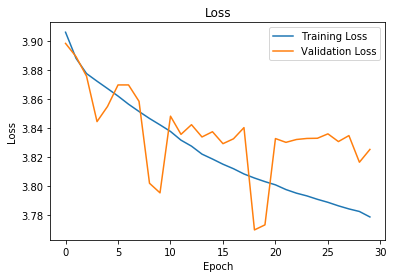

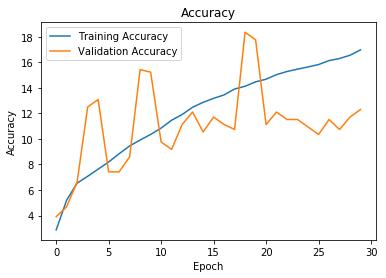

In [15]:
def draw_losses(train_losses=None, val_losses=None, test_losses=None):
    if train_losses!=None:
        plt.plot(np.arange(EPOCHS), train_losses, label='Training Loss')
    if val_losses!=None:
        plt.plot(np.arange(EPOCHS), val_losses, label='Validation Loss')
    if test_losses!=None:    
        plt.plot(np.arange(EPOCHS), test_losses, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./pic/pytorch_model_loss.png')
    plt.show()
    
def draw_accuracy(train_acc=None, val_acc=None, test_acc=None):
    if train_acc!=None:
        plt.plot(np.arange(EPOCHS), train_acc, label='Training Accuracy')
    if val_acc!=None:
        plt.plot(np.arange(EPOCHS), val_acc, label='Validation Accuracy')
    if test_acc!=None:    
        plt.plot(np.arange(EPOCHS), test_acc, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./pic/pytorch_model_acc.png')
    plt.show()
    
draw_losses(train_losses=train_loss_list, val_losses=val_loss_list)
draw_accuracy(train_acc=train_acc_list, val_acc=val_acc_list)

In [18]:
model = LeNet5()
model.load_state_dict(torch.load('./model/pytorch_model.pt'))
model.to(device)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (activ1): Sigmoid()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (activ2): Sigmoid()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (activ3): Sigmoid()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (activ4): Sigmoid()
  (fc3): Linear(in_features=84, out_features=50, bias=True)
  (softmax): Softmax(dim=1)
)

In [21]:
# predict validation set
def compute_accuracy(predictions, labels):
    # Compare predicted labels with ground truth labels
    # correct = (predictions == labels).sum().item()
    correct = torch.eq(predictions, labels).sum().item()
    # Calculate accuracy
    accuracy = correct / labels.size(0) * 100
    return accuracy

pred_label = torch.argmax(model(X_val.to(device)), dim=1)
print(f"Validation acc: {compute_accuracy(pred_label.cpu(), Y_val):.4f} %")

Validation acc: 14.0000 %


In [22]:
# predict test dataset
pred_label = torch.argmax(model(X_test.to(device)), dim=1)
print(f"Test acc: {compute_accuracy(pred_label.cpu(), Y_test):.4f} %")

Test acc: 16.0000 %


#### inference time

In [58]:
# inference time
# Create the model
net = LeNet5().to(device)
# Create a sample input
input_data = torch.randn(BATCH_SIZE, 3, 32, 32).to(device)  # Assuming input is a 3-channel 32x32 image
# Enable evaluation mode
net.eval()
# Measure inference time
start_time = time.time()
output = net(input_data)
# Calculate inference time
inference_time = time.time() - start_time

print(f"Inference time: {inference_time:.8f} seconds")


Inference time: 0.00215507 seconds


#### space complexity and FLOPS

In [25]:
# space complexity & FLOPS
# https://www.zhihu.com/question/65305385
# https://zhuanlan.zhihu.com/p/137719986
# FLOPS：floating point operations per second，意指每秒浮点运算次数，理解为计算速度。是一个衡量硬件性能的指标
# FLOPs：floating point operations的缩写（s表复数），意指浮点运算数，理解为计算量。可以用来衡量算法/模型的复杂度。
# https://github.com/Lyken17/pytorch-OpCounter
input = torch.randn(BATCH_SIZE, 3, 32, 32).to(device)
macs, params = profile(model, inputs=(input, ))
print()
print(f"FLOPs: {macs*2/1e6} MFLOPs, params: {params/1e6} M")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.

FLOPs: 167.738624 MFLOPs, params: 0.065406 M


In [41]:
# with torch.cuda.device(0):
#   net = LeNet5()
#   macs, params = get_model_complexity_info(net, (3, 32, 32), as_strings=False,
#                                            print_per_layer_stat=True, verbose=True)
#   print('{:<30}  {:<8} KFLOPs'.format('Computational complexity: ', macs*2/1e3))
#   print('{:<30}  {:<8} K'.format('Number of parameters: ', params/1e3))

In [30]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        model(X_test.cuda())

In [31]:
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         7.92%     592.000us        99.14%       7.413ms       7.413ms       0.000us         0.00%       1.602ms       1.602ms          -4 b         -20 b           0 b     -35.91 M